In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg as sla, optimize as opt
import matplotlib as mpl

params = {'image.aspect':'equal',
          'savefig.dpi':600,
          'axes.grid':True,
          'font.size':12,
          'text.color':'black',
          'text.usetex':True,
          'image.cmap':'viridis'}

mpl.rcParams.update(params)
np.set_printoptions(linewidth=125, precision = 5)

# General Flow of CP code

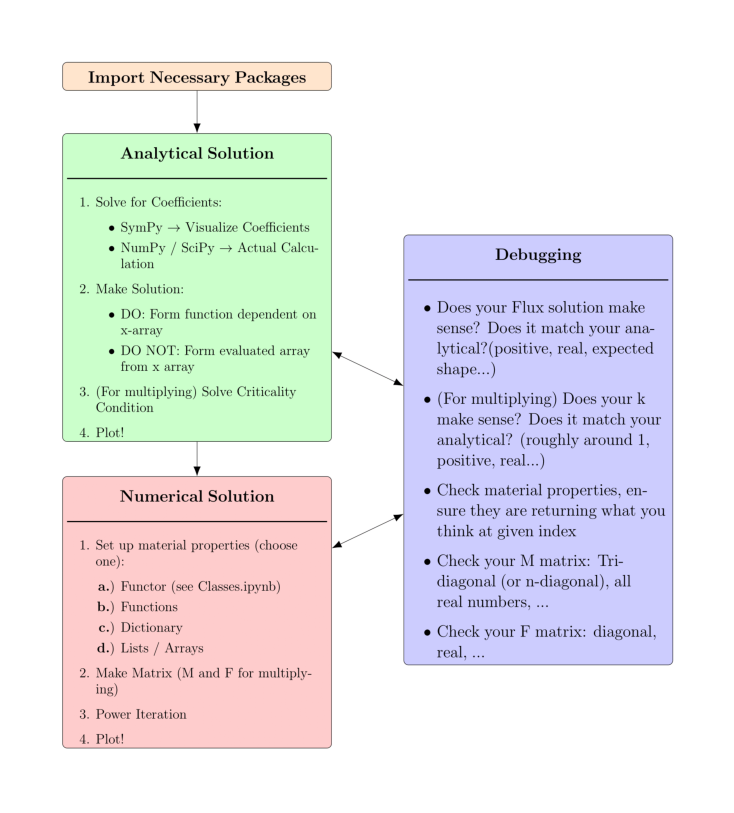

In [2]:
fig = plt.imread('flow.png')
plt.figure(dpi=600, figsize=(5, 1.5)) #remove this to make bigger
plt.imshow(fig)
plt.grid(False)
plt.ylim(1750,70)
plt.xlim(30, 1520)
plt.axis("off")
plt.show()

# Using NumPy / SciPy to Solve for Analytical Coefficients

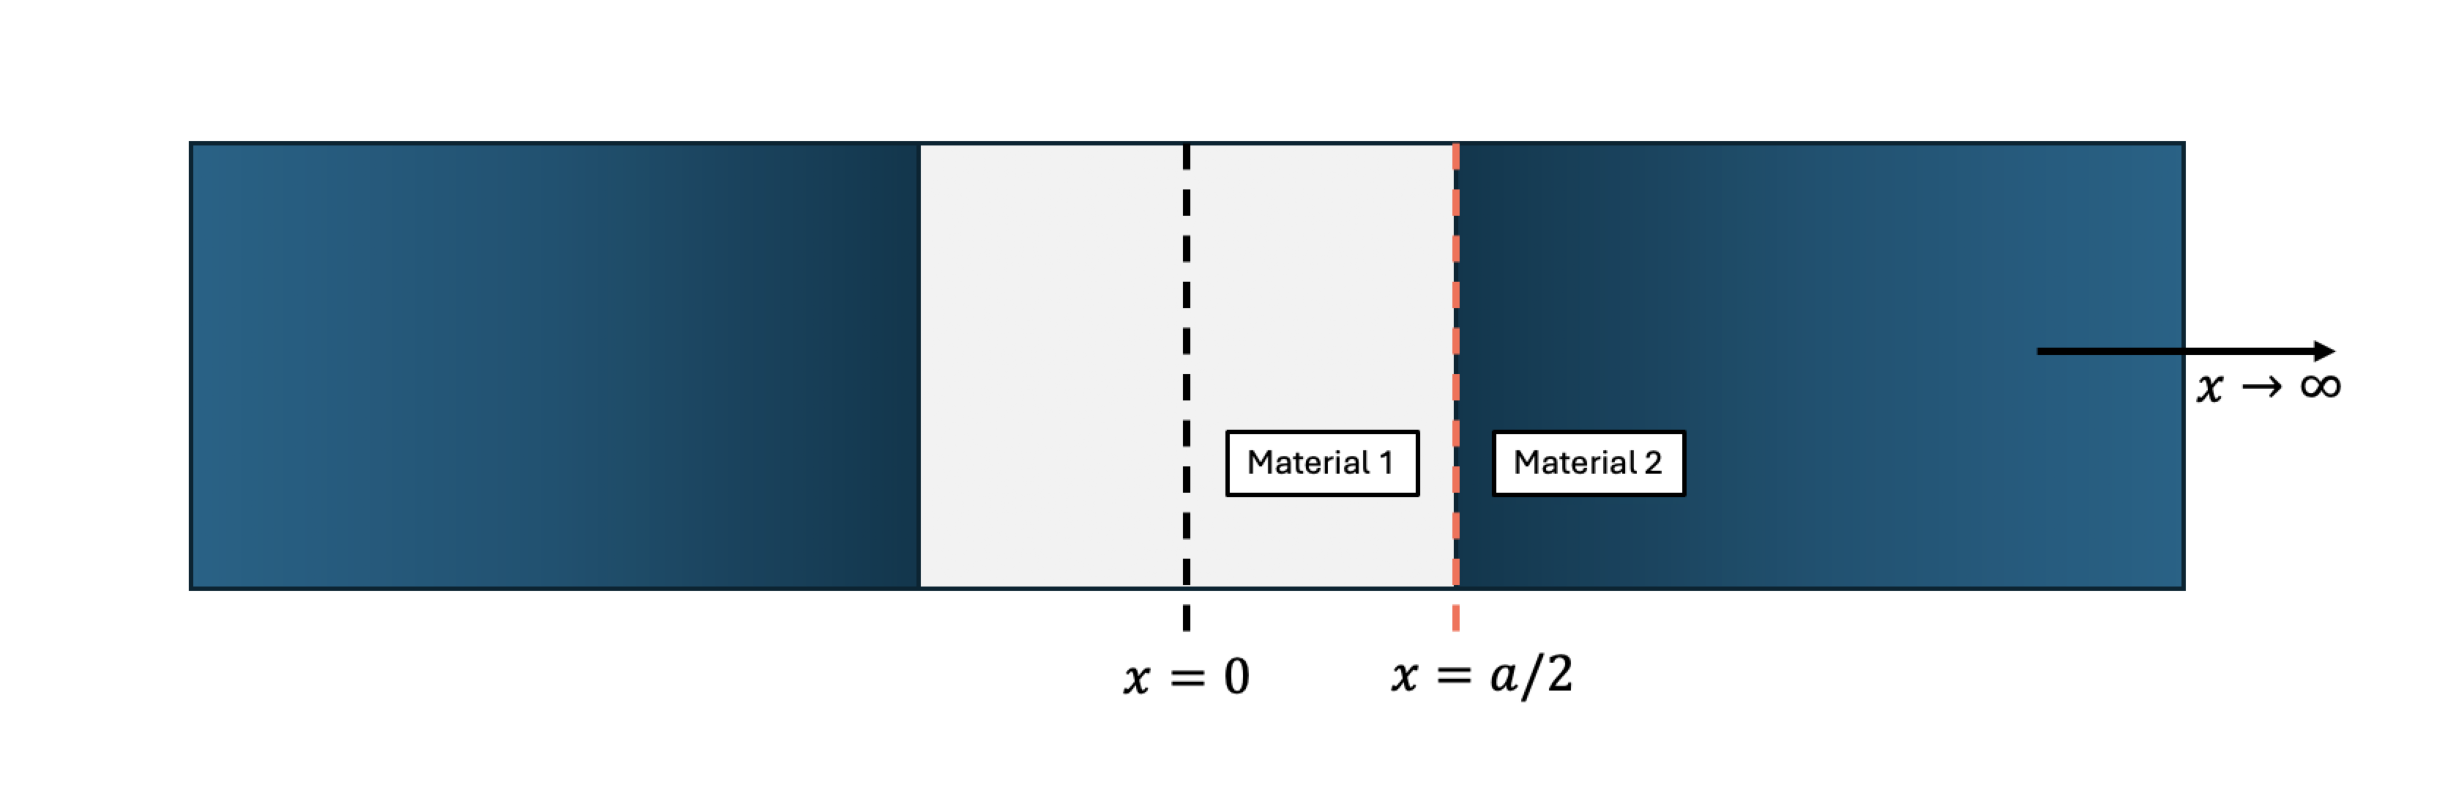

In [3]:
fig = plt.imread('hw4q3pb.png')
plt.figure(figsize=(5, 1.5), dpi=600) #remove this to make bigger
plt.imshow(fig)
plt.grid(False)
plt.axis("off")
plt.show()

## General Solutions
$$ \phi_1(x) = C_1\sinh(\frac{x}{L}) + C_2\cosh(\frac{x}{L}) + \frac{SL^2}{D}$$
$$ \phi_2(x) = C_3e^{\frac{x}{L}} + C_4e^{\frac{-x}{L}} $$

## Boundary Conditions
$$ \nabla \phi_1(0) = 0 \quad\quad\rightarrow\quad\quad \frac{C_1}{L}\cosh(0) + \frac{C_2}{L}\sinh(0) = 0$$

$$ \phi_1(a/2) = \phi_2(a/2) \quad\quad\rightarrow\quad\quad C_1\sinh(x_i) + C_2\cosh(x_i) - C_3e^{x_i} - C_4e^{-x_i} =  -\frac{SL^2}{D}$$

$$ -D_1\nabla\phi_1(a/2) = -D_2\nabla\phi_2(a/2) \quad\quad\rightarrow\quad\quad \frac{-D_1C_1}{L}\cosh(x_i) + \frac{-D_1C_2}{L}\sinh(x_i) + \frac{-D_2C_3}{L}e^{x_i} + \frac{-D_2C_4}{L}e^{-x_i} = 0$$

$$ \phi_2(\infty) = 0 \quad\quad\rightarrow\quad\quad C_3e^{\infty} + C_4e^{-\infty} = 0$$

In [4]:
#arbitrary numbers
a, L1, L2 = 20, 5, 3
D1, D2 = 1.7, 1
S = 1e10
x_i = a/2

LHS = np.array(
    [[np.cosh(0), np.sinh(0), 0, 0],
    [np.sinh(x_i/L1), np.cosh(x_i/L1), -np.exp(x_i/L2), -np.exp(-x_i/L2)],
    [-D1 / L1 * np.cosh(x_i/L1), -D1 / L1 * np.sinh(x_i/L1), D2 / L2 * np.exp(x_i/L2), -D2 / L2 * np.exp(-x_i/L2)],
    [0, 0, 1, 0]])

RHS = np.array(
    [0,
     -S * L1**2 / D1,
     0,
     0
    ])

#solving for the coefficients
c1, c2, c3, c4 = sla.solve(LHS, RHS)

# Setting Up Finite-Difference Matrix

### M Matrix

$$ \mathbf{M}\phi \quad\rightarrow\quad \frac{-D_{i}}{h^2}\phi_{i-1} + \biggr[2\frac{D_i}{h^2} + \Sigma_{a,i}\biggr]\phi_i -\frac{D_{i}}{h^2}\phi_{i+1} $$

[[ 0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [-0.51425  1.092   -0.51425  0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.      -0.51425  1.092   -0.51425  0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.      -0.51425  1.092   -0.51425  0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.      -0.51425  1.092   -0.51425  0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.      -0.51425  1.092   -0.51425  0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.      -0.51425  1.092   -0.51425  0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.      -0.51425  1.092   -0.51425  0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.      -0.51425  1.092   -0.51425  0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.      -0.51425

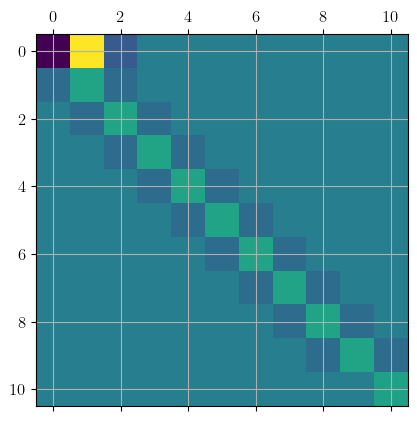

In [5]:
a = 20
N = 10
h = a/(N+1)
siga, D = .0635, 1.7

M = np.zeros((N+1,N+1))

def row(h):
    left = -D / h**2
    right = -D / h**2
    center = 2 * D / h**2 + siga
    return [left, center, right]


for i in range(1,N):
    M[i, i-1:i+2] = row(h)
print(M,"\n")

#Neumann
neumann_BC = [-3, 4, -1]
M[0, 0:3] = neumann_BC
print(M,"\n")

#Dirichlet 
dirichlet_BC = 1
M[-1, -1] = dirichlet_BC
print(M)
plt.matshow(M)

### F Matrix

$$ \mathbf{F}\phi \quad\rightarrow\quad \nu\Sigma_{f,i}\phi_i $$

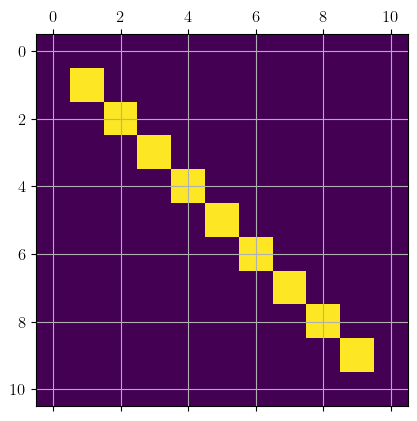

In [7]:
sigf = 0.02

#Be careful about boundary conditions!!

F = np.zeros_like(M)  #Matrix...

np.fill_diagonal(F, sigf)

#BCs
F[0,0] = 0 #neumann
F[-1,-1] = 0 # dirichlet

plt.matshow(F)  #This shows the matrix graphically

# Power Iteration

$$ M\phi_{i+1} = \frac{1}{k}F\phi_i$$

$$ k_{i+1} = \frac{\int_VF\phi_{i+1}}{\int_VM\phi_{i+1}} $$


Iteration	k			Residual
--------------------------------------------------
0		1			N/A
1		0.2114925007198391	-3.728300041828361
2		0.22916331889286432	0.07711015121615715
3		0.23489244988418168	0.024390443346059956
4		0.23709318927286577	0.00928217042182222
5		0.2380016646844421	0.0038170968794728204
6		0.23838657536316055	0.0016146491392482222
7		0.23855127021783104	0.0006903960499564909
8		0.23862202518284636	0.0002965148123317921
9		0.23865247674218412	0.00012759791875386326
10		0.2386655933495938	5.495809942940772e-05
11		0.23867124538286208	2.368124932354232e-05
12		0.238673681345675	1.0206248125782104e-05
13		0.23867473131559938	4.399166675945236e-06
14		0.23867518390324094	1.896249262939297e-06
15		0.23867537899462438	8.173921594207627e-07
16		0.23867546309116658	3.523468274159513e-07
-------------------------------------------------- 

Solve Converged in 16 Iterations.


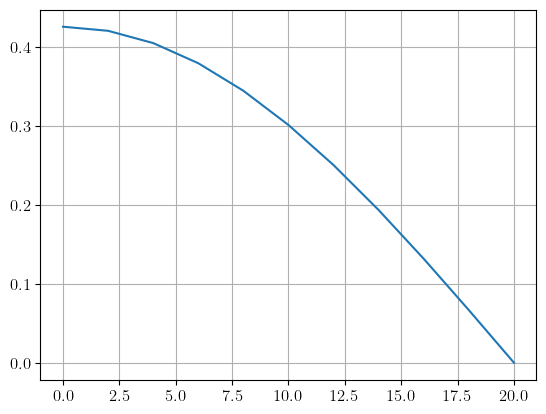

In [8]:
phi0 = np.ones(M.shape[0])
k0 = 1

x = np.linspace(0, a, M.shape[0])

tol = 1e-6


print('\nIteration\tk\t\t\tResidual')
print('-'*50)
print(f'{0}\t\t{k0}\t\t\tN/A')
i = 1
while True:
    rhs = np.inner(F, phi0) / k0 # or np.matmul
    
    phi = sla.solve(M, rhs)
    phi /= sla.norm(phi)

    k = np.trapezoid( np.inner(F, phi) , dx=h)
    k /= np.trapezoid( np.inner(M, phi) , x=x)

    flux_check = sla.norm(phi - phi0, 2) / sla.norm(phi0, 2) <= tol

    k_check = np.abs((k - k0) / k) <= tol

    print(f'{i}\t\t{k}\t{((k - k0) / k)}')
    if flux_check & k_check:
        print("-"*50,f'\n\nSolve Converged in {i} Iterations.')
        break
    i+=1
    phi0 = phi
    k0 = k

plt.plot(x, phi)
plt.show()

# Solving Transcendental Criticality Condition

Criticality condition:

$$ B\cos(B) = 0 $$

$$ B^2 = \frac{\Sigma_a - \frac{1}{k}\nu\Sigma_f}{D} $$

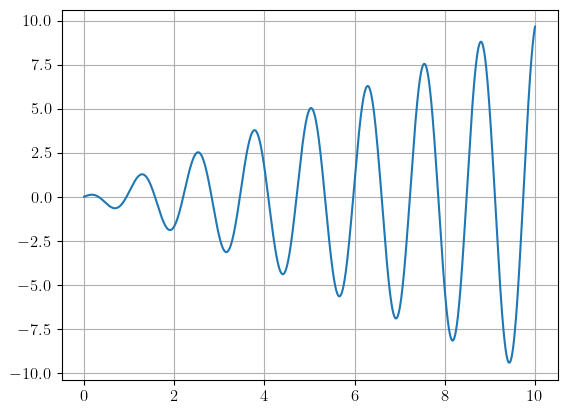

In [9]:
#recall scipy.optimize = opt

def crit(k):
    return np.cos(k*5)*k

#lets plot this condition

ks = np.linspace(0, 10, 1000)

fig, ax = plt.subplots()
ax.plot(ks, crit(ks))

To find the root, use `scipy.optimize.root` (simpler) or jointly with `scipy.optimize.minimize` (harder, safer).

Function signatures:

`root(fun, x0)`

`minimize(fun, x0, bounds)`

In [14]:
opt.root(fun = crit, x0 = 1)

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.731e-16]
       x: [ 9.425e-01]
  method: hybr
    nfev: 9
    fjac: [[-1.000e+00]]
       r: [-4.712e+00]
     qtf: [-4.680e-11]

In [15]:
def min_crit(k):
    return np.abs(k)

opt.minimize(fun = min_crit, x0 = 1, bounds = [ (0,2) ])

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.0
        x: [ 0.000e+00]
      nit: 1
      jac: [ 1.000e+00]
     nfev: 4
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>